In [1]:
import numpy as np
import pandas as pd   
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fix random generator seed (for reproducibility of results)
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

c:\Users\jcrl\miniconda3\envs\ModelML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Data/data_pre.csv")


In [3]:
df = df.drop(["Unnamed: 0"], axis=1)

In [4]:
df["DEP_TIME"] = pd.to_datetime(df["DEP_TIME"]).dt.hour

In [5]:
df["FL_DATE"]=pd.to_datetime(df["FL_DATE"]).dt.dayofyear

In [6]:
X = df.drop(["DEP_DELAY"], axis=1)
print(X.shape)
X = X.to_numpy()


y = df["DEP_DELAY"].values

(54180, 15)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std

X_test_mean = X_test.mean(axis=0)
X_test_std = X_test.std(axis=0)
X_test = (X_test - X_test_mean) / X_test_std

# standardize target
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std

y_test_mean = y_test.mean()
y_test_std = y_test.std()
y_test = (y_test - y_test_mean) / y_test_std


In [8]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [9]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)

# Convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean


corr, mae, rae, rmse, r2 = compute_error(y_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: -0.011
MAE: 3533056383.960
RMSE: 5206834839.693
R2: 0.000


In [10]:
def model(X, obs=None):
    
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [11]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train).float()
y_train_small = torch.tensor(y_train).float()

In [12]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [06:51,  2.92it/s, step size=2.43e-02, acc. prob=0.914]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.01     -0.00     -0.01      0.01    880.22      1.00
   beta[0]     -0.00      0.02     -0.00     -0.04      0.03    385.23      1.00
   beta[1]      0.23      0.01      0.23      0.22      0.24    891.87      1.00
   beta[2]      0.12      0.01      0.12      0.11      0.12    973.74      1.00
   beta[3]     -0.04      0.02     -0.04     -0.08     -0.01    399.30      1.00
   beta[4]     -0.14      0.01     -0.14     -0.15     -0.13    708.99      1.00
   beta[5]      0.03      0.32      0.04     -0.42      0.57     87.19      1.03
   beta[6]     -0.04      0.41     -0.03     -0.61      0.65     87.03      1.03
   beta[7]     -0.01      0.07     -0.01     -0.11      0.11     86.39      1.04
   beta[8]     -0.03      0.28     -0.03     -0.42      0.44     87.12      1.03
   beta[9]     -0.00      0.09      0.00     -0.12      0.14     87.08      1.03
  beta[10]     -0.03      0

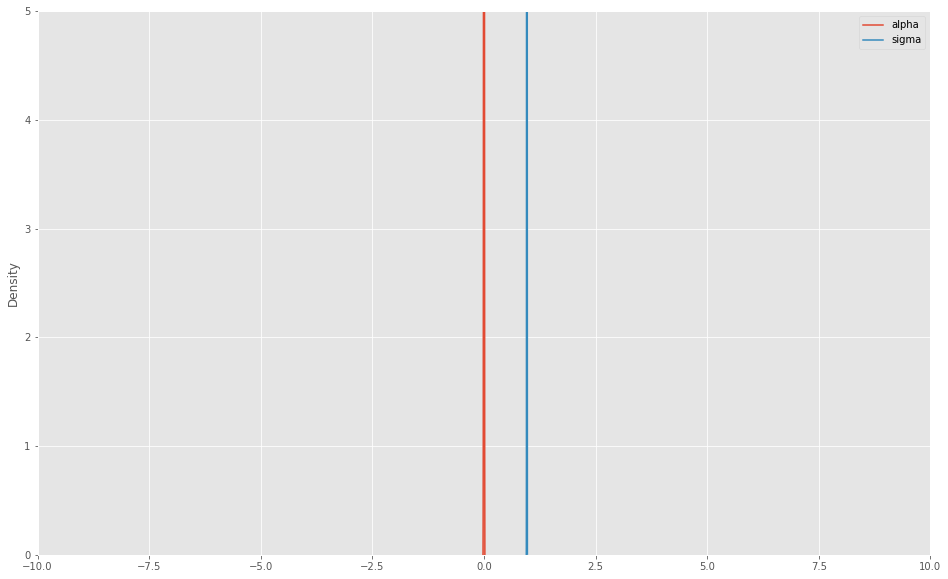

In [13]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.distplot(posterior_samples["alpha"])
sns.distplot(posterior_samples["sigma"])

# Alternate plotting due to deprecated distplot-function
#sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
#sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

plt.legend(["alpha", "sigma"])
plt.axis([-10,10,0,5])
plt.show()

In [14]:
print(posterior_samples["alpha"].shape)
print(posterior_samples["beta"].shape)

beta_hat=torch.mean(posterior_samples["beta"], axis=0)
alpha_hat=torch.mean(posterior_samples["alpha"], axis=0)

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)

torch.Size([1000])
torch.Size([1000, 15])


In [15]:
# Convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.288
MAE: 21.034
RMSE: 36.340
R2: 0.083


Pyro: Train on full dataset using Stochastic Variational Inference (SVI)

In [16]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [17]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

In [18]:
# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [19]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 108805.5
[100] ELBO: 97313.8
[200] ELBO: 93261.9
[300] ELBO: 93635.5
[400] ELBO: 94182.6
[500] ELBO: 89517.2
[600] ELBO: 84914.8
[700] ELBO: 72486.9
[800] ELBO: 76502.7
[900] ELBO: 74155.0
[1000] ELBO: 75196.9
[1100] ELBO: 68537.7
[1200] ELBO: 64189.5
[1300] ELBO: 56700.5
[1400] ELBO: 64563.1
[1500] ELBO: 57034.7
[1600] ELBO: 54482.4
[1700] ELBO: 51326.6
[1800] ELBO: 52857.5
[1900] ELBO: 52318.3
[2000] ELBO: 51898.1
[2100] ELBO: 50423.7
[2200] ELBO: 50591.0
[2300] ELBO: 50414.7
[2400] ELBO: 50524.8
[2500] ELBO: 50497.9
[2600] ELBO: 50512.6
[2700] ELBO: 50394.7
[2800] ELBO: 50256.7
[2900] ELBO: 50246.1
[3000] ELBO: 50400.7
[3100] ELBO: 50260.3
[3200] ELBO: 50246.0
[3300] ELBO: 50262.5
[3400] ELBO: 50249.3
[3500] ELBO: 50206.6
[3600] ELBO: 50253.8
[3700] ELBO: 50180.3
[3800] ELBO: 50215.0
[3900] ELBO: 50244.0


In [20]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [21]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# Convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.288
MAE: 21.039
RMSE: 36.339
R2: 0.083


2.3 Pyro: Heteroscedastic regression

In [22]:
def heteroscedastic_model(X, obs=None):
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))                 # Prior for the bias/intercept of the mean
    beta_mu  = pyro.sample("beta_mu", dist.Normal(torch.zeros(X.shape[1]), 
                                               torch.ones(X.shape[1])).to_event())     # Priors for the regression coeffcients of the mean
    alpha_v = pyro.sample("alpha_v", dist.Normal(0., 1.))                   # Prior for the bias/intercept of the variance
    beta_v  = pyro.sample("beta_v", dist.Normal(torch.zeros(X.shape[1]), 
                                               torch.ones(X.shape[1])).to_event())     # Priors for the regression coeffcients of the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha_mu + X.matmul(beta_mu), torch.exp(alpha_v + X.matmul(beta_v))), obs=obs)
        
    return y

In [23]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [24]:
# Define guide function
guide = AutoMultivariateNormal(heteroscedastic_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 8000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(heteroscedastic_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 200 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 81964182.7
[200] ELBO: 143554.9
[400] ELBO: 58855.8
[600] ELBO: 57575.5
[800] ELBO: 54087.1
[1000] ELBO: 58191.1
[1200] ELBO: 50152.9
[1400] ELBO: 48922.5
[1600] ELBO: 48997.6
[1800] ELBO: 49260.6
[2000] ELBO: 48928.1
[2200] ELBO: 47794.5
[2400] ELBO: 47614.5
[2600] ELBO: 47732.0
[2800] ELBO: 47538.7
[3000] ELBO: 47796.8
[3200] ELBO: 47459.3
[3400] ELBO: 47485.2
[3600] ELBO: 47447.1
[3800] ELBO: 47338.1
[4000] ELBO: 47385.9
[4200] ELBO: 47373.8
[4400] ELBO: 47308.8
[4600] ELBO: 47287.5
[4800] ELBO: 47307.2
[5000] ELBO: 47271.7
[5200] ELBO: 47309.7
[5400] ELBO: 47265.3
[5600] ELBO: 47270.1
[5800] ELBO: 47274.4
[6000] ELBO: 47253.6
[6200] ELBO: 47253.6
[6400] ELBO: 47247.2
[6600] ELBO: 47271.9
[6800] ELBO: 47249.4
[7000] ELBO: 47287.0
[7200] ELBO: 47269.4
[7400] ELBO: 47254.4
[7600] ELBO: 47275.6
[7800] ELBO: 47251.3


In [25]:
from pyro.infer import Predictive

predictive = Predictive(heteroscedastic_model, guide=guide, num_samples=1000,
                        return_sites=("alpha_mu", "beta_mu", "alpha_v", "beta_v"))
samples = predictive(X_train_torch, y_train_torch)

In [26]:
alpha_samples = samples["alpha_mu"].detach().numpy()
beta_samples = samples["beta_mu"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.285
MAE: 20.999
RMSE: 36.477
R2: 0.076


In [27]:
alpha_v_samples = samples["alpha_v"].detach().numpy()
beta_v_samples = samples["beta_v"].detach().numpy()
sigma_hat = np.mean(np.exp(alpha_v_samples.T + np.dot(X_test, beta_v_samples[:,0].T)), axis=1)

In [28]:
np.set_printoptions(precision=3)
print(sigma_hat[:10])

[0.755 0.544 0.928 0.619 0.888 0.591 0.815 1.189 0.765 0.973]


NNET

In [37]:
X = df.drop(["DEP_DELAY"], axis=1)
print(X.shape)
X = X.to_numpy()


y = df["DEP_DELAY"].values

(54180, 15)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# standardize input features

In [39]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

In [40]:
def nnet_model(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=4, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # The generative process
    with pyro.plate("observations"):
        prediction_mean = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
        
    return y

In [41]:
# Prepare data for Pyro by converting it into PyTorch tensors
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [42]:
# Define guide function
guide = AutoDiagonalNormal(nnet_model)

# Reset parameter values
pyro.clear_param_store()

In [43]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4451795098.4
[500] ELBO: 3943992469.1
[1000] ELBO: 3713619224.1
[1500] ELBO: 3635634965.5
[2000] ELBO: 3587111816.5
[2500] ELBO: 3528927022.8
[3000] ELBO: 3449505276.6
[3500] ELBO: 3426802283.8
[4000] ELBO: 3411880151.0
[4500] ELBO: 3394207828.8
[5000] ELBO: 3378704802.4
[5500] ELBO: 3363890703.4
[6000] ELBO: 3293962787.9
[6500] ELBO: 3370693132.2
[7000] ELBO: 3256527538.7
[7500] ELBO: 3254951747.9
[8000] ELBO: 3300539841.1
[8500] ELBO: 3288335911.2
[9000] ELBO: 3234804094.7
[9500] ELBO: 3232599258.3


In [46]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test).float()

C:\Users\jcrl\AppData\Local\Temp\ipykernel_13444\327537019.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


In [47]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(nnet_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

In [36]:
y_pred = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae)

MAE: 32.84330776734985


In [48]:
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_test_std + y_test_mean

corr, mae, rae, rmse, r2 = compute_error(y_test, samples)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 17880